## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import math
from abc import abstractmethod
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from torchdiffeq import odeint
from torch.nn import Parameter
from torch.distributions import Independent, Normal

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.models import OrdinaryLFM, MultiOutputGP
from lafomo.plot import Plotter
from lafomo.trainer import TranscriptionalTrainer

import numpy as np

In [2]:
class TranscriptionalRegulationLFM(OrdinaryLFM):
    def __init__(self, gp_model, config: VariationalConfiguration, dataset):
        super().__init__(gp_model, config, dataset)
        self.decay_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.basal_rate = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.sensitivity = Parameter(0.2 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)

        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)

        h = self.basal_rate + self.sensitivity * f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h


In [3]:
dataset = P53Data(replicate=0, data_dir='../data')
num_genes = 5
num_tfs = 1
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    learn_inducing=False,
    num_samples=80,
    kernel_scale=False,
    initial_conditions=False
)

# The shape of the inducing points should be (2 x m x 1) - so that we learn different inducing
# points for each output
num_inducing = 12
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float32)

gp_model = MultiOutputGP(inducing_points, num_tfs)
lfm = TranscriptionalRegulationLFM(gp_model, config, dataset)

# Use the adam optimizer
optimizer = torch.optim.Adam(lfm.parameters(), lr=0.08)

class P53ConstrainedTrainer(TranscriptionalTrainer):
    def extra_constraints(self):
        self.lfm.sensitivity[3] = np.float64(1.)
        self.lfm.decay_rate[3] = np.float64(0.8)

trainer = P53ConstrainedTrainer(lfm, optimizer, dataset)

step_size = 1e-1
plotter = Plotter(lfm, dataset.gene_names)

print(lfm.inducing_points)

tensor([[[ 0.0000],
         [ 1.0909],
         [ 2.1818],
         [ 3.2727],
         [ 4.3636],
         [ 5.4545],
         [ 6.5455],
         [ 7.6364],
         [ 8.7273],
         [ 9.8182],
         [10.9091],
         [12.0000]]])


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\torch\optim\adam.py:48: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


### Outputs prior to training:

In [ ]:
plotter.plot_kinetics()
plotter.plot_outputs(t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=dict(step_size=step_size))
plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)

In [4]:
lfm.train()

trainer.train(100, report_interval=10, rtol=step_size)

Epoch 001/100 - Loss: 9.17 (9.17  0.00  ) λ: 0.6163437366485596
Epoch 011/100 - Loss: 6.55 (6.29  0.26  ) λ: 0.5385683178901672
Epoch 021/100 - Loss: 5.09 (4.40  0.69  ) λ: 0.8202579021453857
Epoch 031/100 - Loss: 4.23 (3.29  0.94  ) λ: 0.905936062335968
Epoch 041/100 - Loss: 4.08 (2.89  1.19  ) λ: 0.7232258319854736
Epoch 051/100 - Loss: 3.59 (2.36  1.23  ) λ: 0.6750133633613586
Epoch 061/100 - Loss: 3.86 (2.66  1.21  ) λ: 0.6308411359786987
Epoch 071/100 - Loss: 5.67 (4.50  1.17  ) λ: 0.6554386019706726
Epoch 081/100 - Loss: 4.58 (3.43  1.15  ) λ: 0.6920077800750732
Epoch 091/100 - Loss: 2.87 (1.85  1.02  ) λ: 0.660354495048523


torch.Size([5, 80])


C:\Users\Jacob\Documents\proj\lafomo\lafomo\plot\plotter.py:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


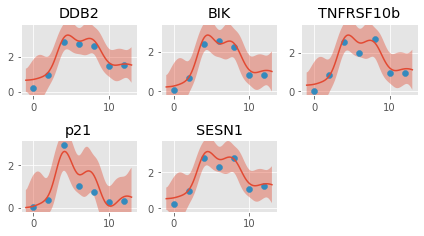

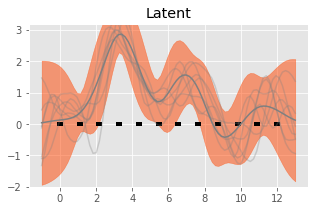

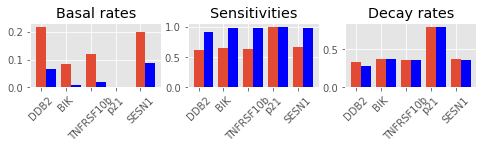

In [6]:
lfm.eval()

plotter.plot_outputs(t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=dict(step_size=step_size))

plotter.plot_latents(t_predict, ylim=(-2, 3.2), plot_barenco=False, plot_inducing=False)

plotter.plot_kinetics()